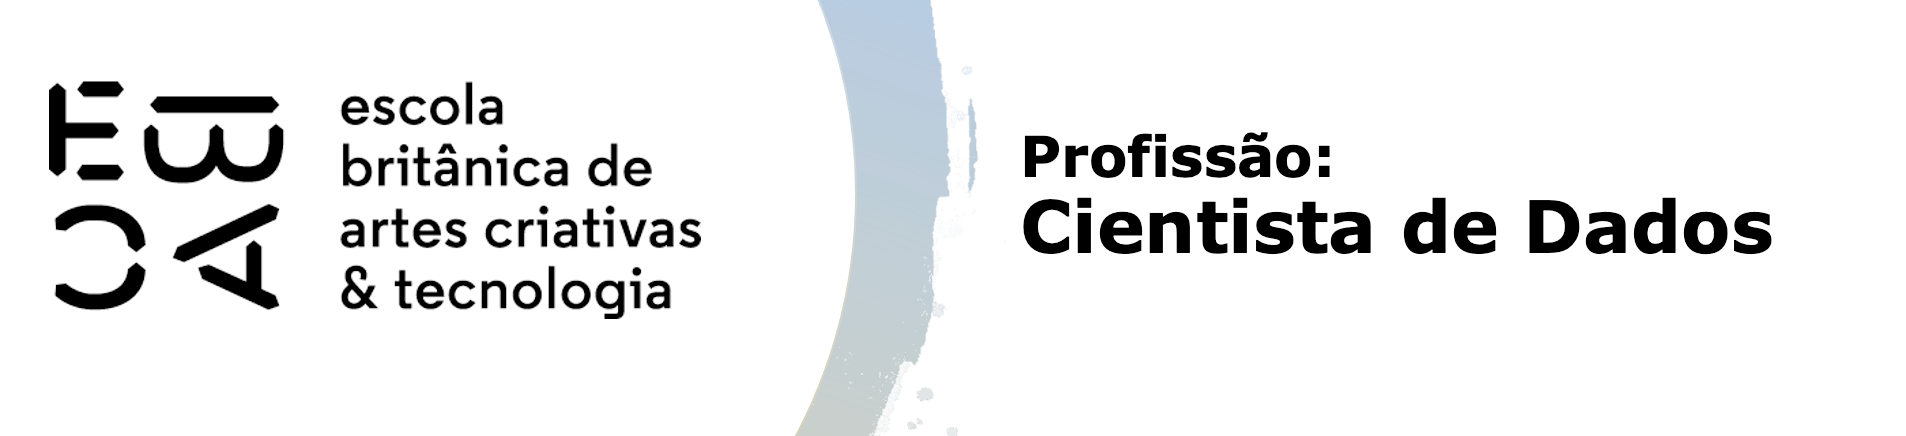

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [13]:

df = pd.read_feather('credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [15]:
#convertendo data_ref para o formato datetime:
df['data_ref'] = pd.to_datetime(df['data_ref'])

In [ ]:
#definindo a data de corte:
data_corte = df['data_ref'].max() - pd.DateOffset(months=3)
validacao_oot = df[df['data_ref'] > data_corte]

In [ ]:
#definindo a base de treinamento:
treinamento = df[df['data_ref'] <= data_corte]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [17]:
#print numero de linhas:
num_linhas = df.shape[0]
print(f"Número total de linhas: {num_linhas}")

#print contagem mensal:
df['data_ref'] = pd.to_datetime(df['data_ref'])  
df['mes'] = df['data_ref'].dt.to_period('M')  
contagem_mensal = df['mes'].value_counts().sort_index()
print("\nNúmero de linhas para cada mês:")
print(contagem_mensal)

#print da descritiva univariada de variaveis quantitativas:
variaveis_quantitativas = df.select_dtypes(include=['float64', 'int64'])
descritiva_quantitativa = variaveis_quantitativas.describe()
print("\nDescritiva básica univariada (variáveis quantitativas):")
print(descritiva_quantitativa)

#print da descritiva univariada de variaveis qualitativas:
variaveis_qualitativas = df.select_dtypes(include=['object'])
descritiva_qualitativa = {col: df[col].value_counts() for col in variaveis_qualitativas.columns}
print("\nDescritiva básica univariada (variáveis qualitativas):")
for col, counts in descritiva_qualitativa.items():
    print(f"\n{col}:")
    print(counts)

Número total de linhas: 750000

Número de linhas para cada mês:
mes
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64

Descritiva básica univariada (variáveis quantitativas):
               index     qtd_filhos          idade  tempo_emprego  \
count  750000.000000  750000.000000  750000.000000  624043.000000   
mean     8319.272793       0.433251      43.804733       7.748574   
std      4809.281774       0.739379      11.229868       6.687455   
min         0.000000       0.000000      22.000000       0.117808   
25%      4147.000000       0.000000      34.000000       3.049315   
50%      8324.000000       0.000000      43.000000       6.046575   
75%     12487.000000       1.000000      53.000000      10.183562   
max     16649.000000      14.0000

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Matriz de Correlação:
                          index  qtd_filhos     idade  tempo_emprego  \
index                  1.000000    0.030967 -0.047098      -0.034562   
qtd_filhos             0.030967    1.000000 -0.370234      -0.075299   
idade                 -0.047098   -0.370234  1.000000       0.330063   
tempo_emprego         -0.034562   -0.075299  0.330063       1.000000   
qt_pessoas_residencia  0.032696    0.890352 -0.341151      -0.066361   
renda                 -0.011548   -0.041886  0.101772       0.496360   

                       qt_pessoas_residencia     renda  
index                               0.032696 -0.011548  
qtd_filhos                          0.890352 -0.041886  
idade                              -0.341151  0.101772  
tempo_emprego                      -0.066361  0.496360  
qt_pessoas_residencia               1.000000 -0.047790  
renda                              -0.047790  1.000000  


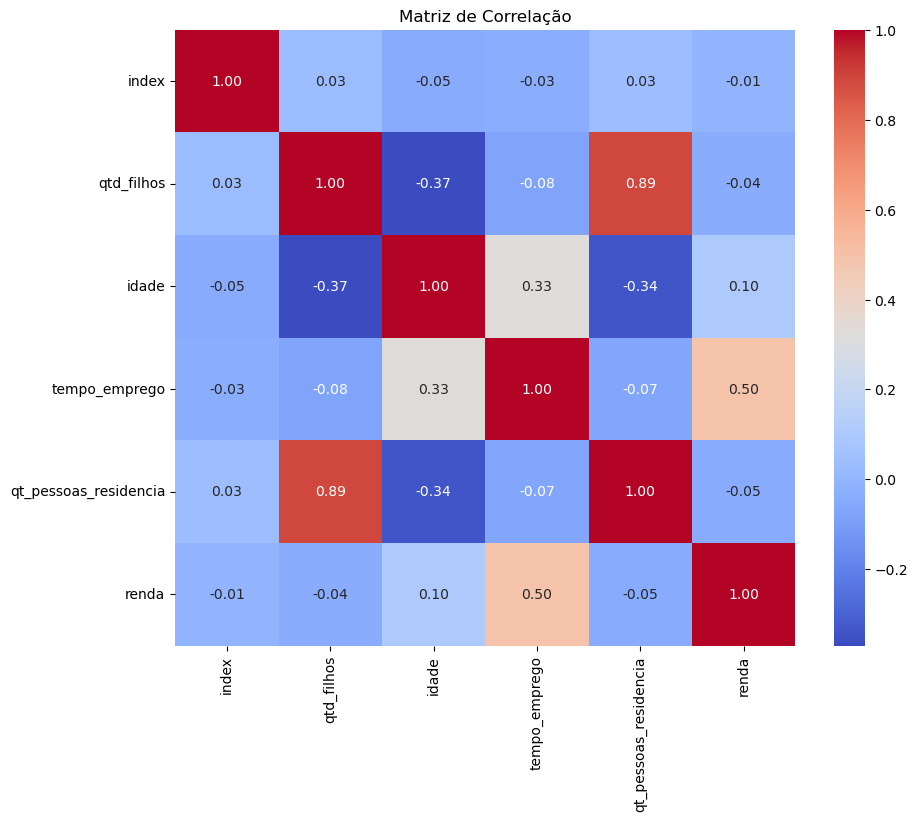


Tabela de Contingência entre sexo e posse_de_veiculo:
posse_de_veiculo       N       S
sexo                            
F                 371028  133552
M                  86926  158494

Tabela de Contingência entre sexo e posse_de_imovel:
posse_de_imovel       N       S
sexo                           
F                156662  347918
M                 89646  155774

Tabela de Contingência entre sexo e tipo_renda:
tipo_renda  Assalariado  Bolsista  Empresário  Pensionista  Servidor público
sexo                                                                        
F                235395       361      113774       108016             47034
M                150345         0       58938        18249             17888

Tabela de Contingência entre sexo e educacao:
educacao  Fundamental   Médio  Pós graduação  Superior completo  \
sexo                                                              
F                5403  342166            591             137952   
M                3172  164

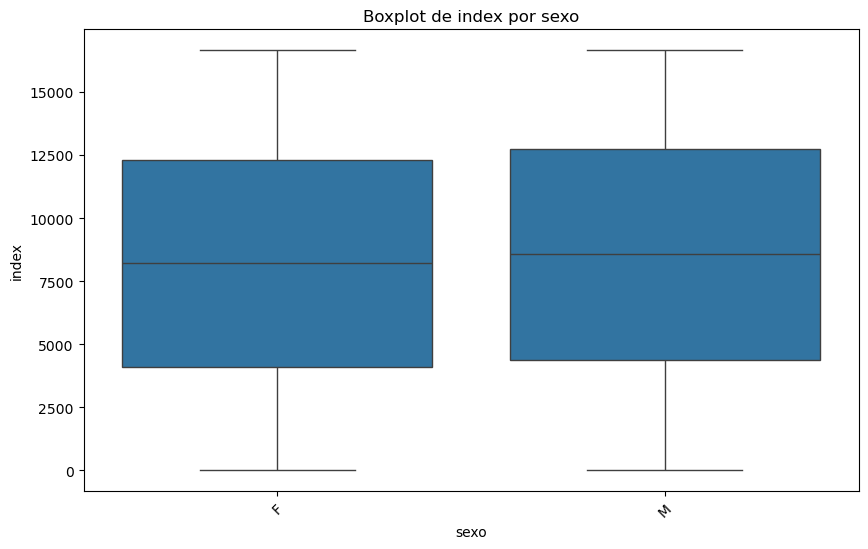

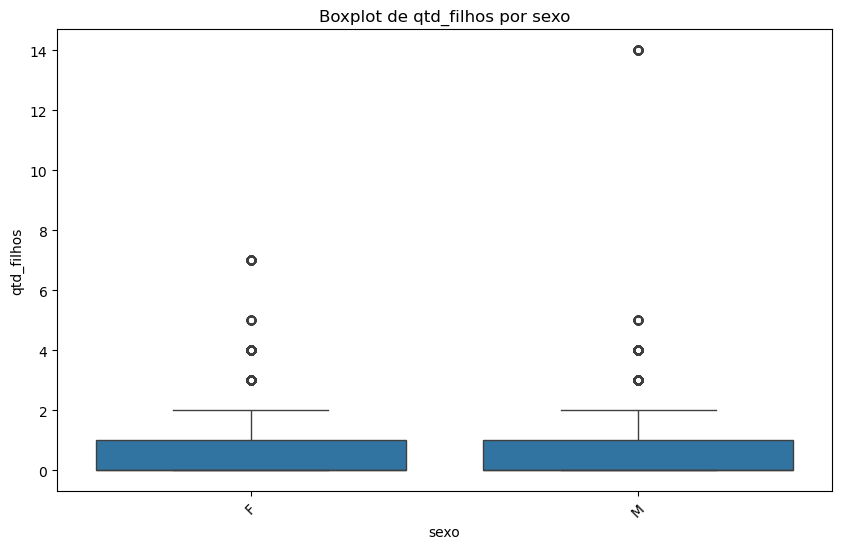

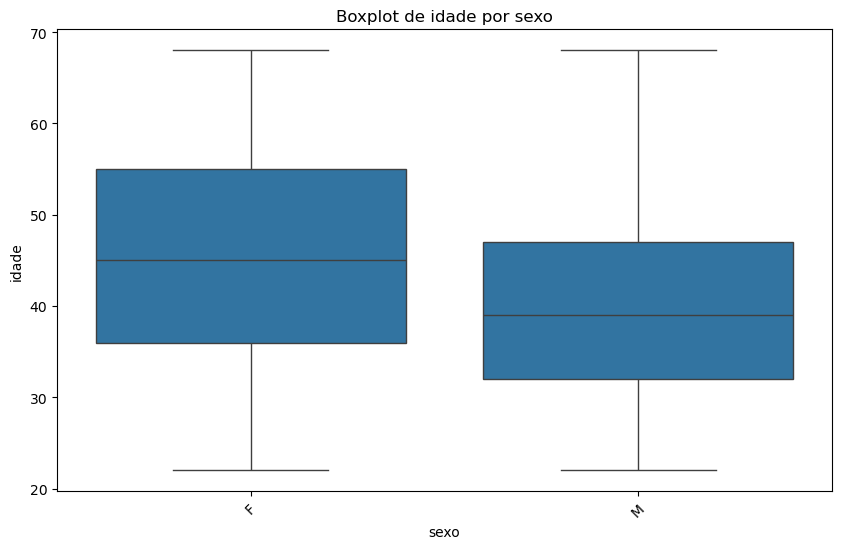

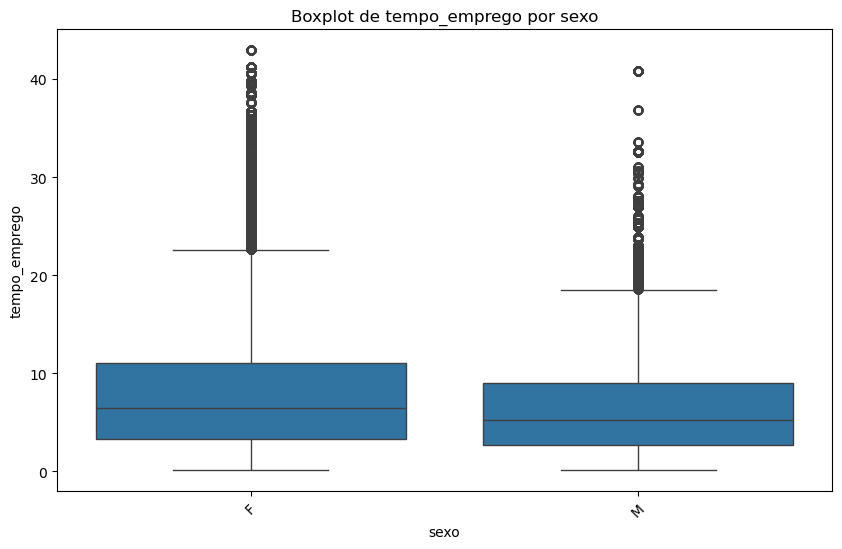

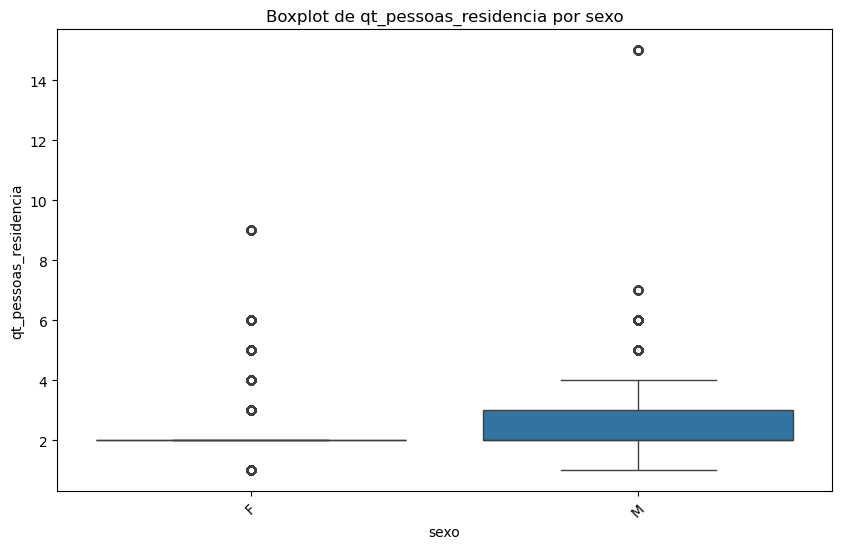

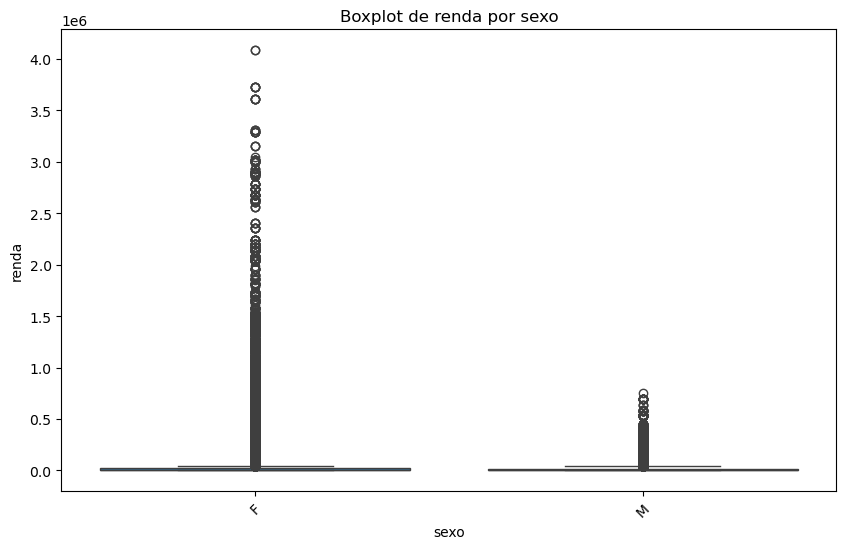

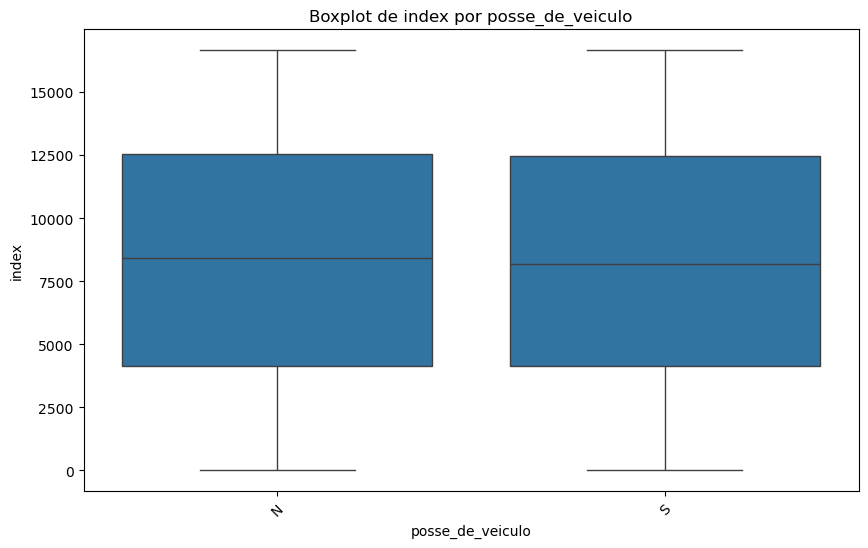

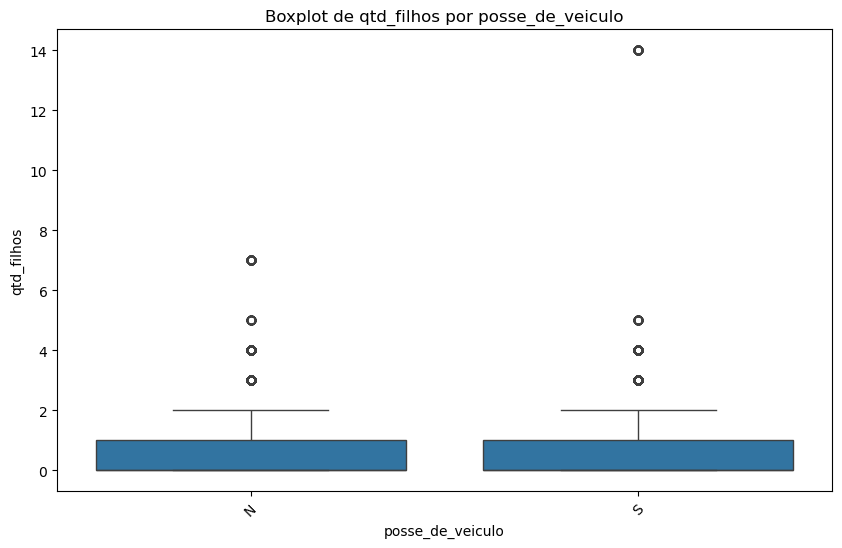

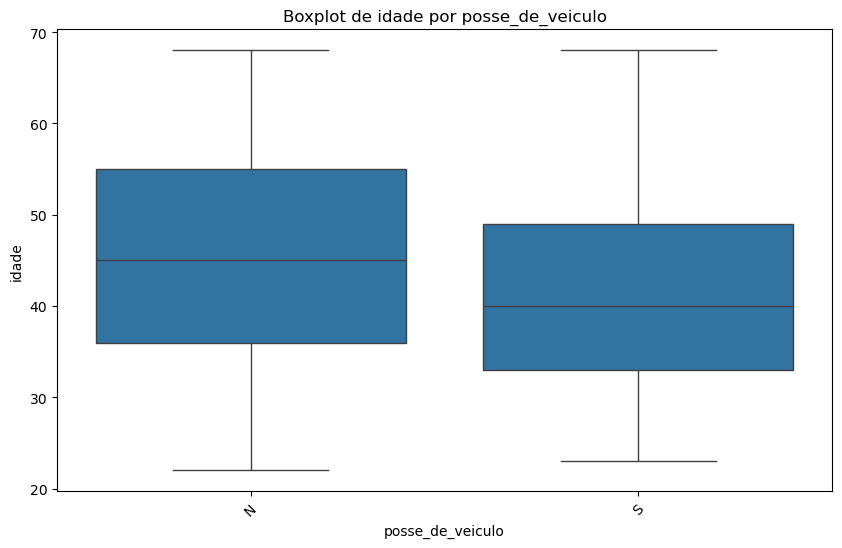

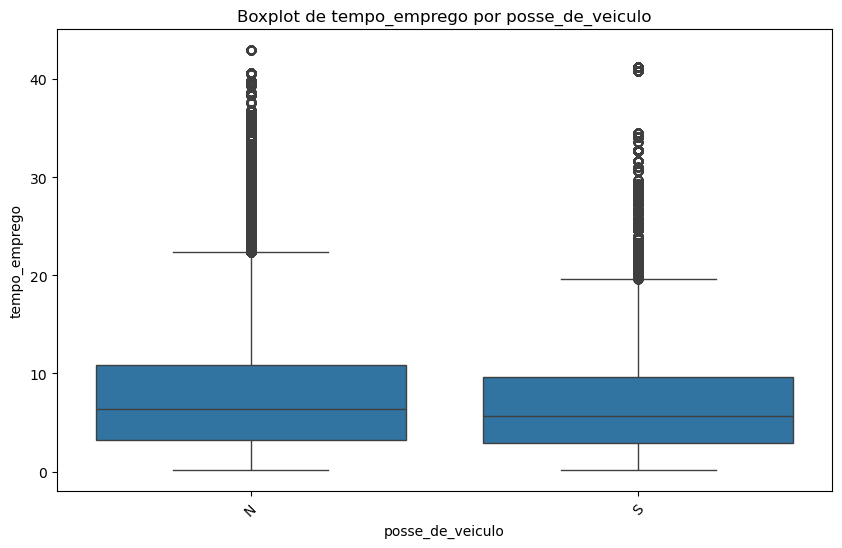

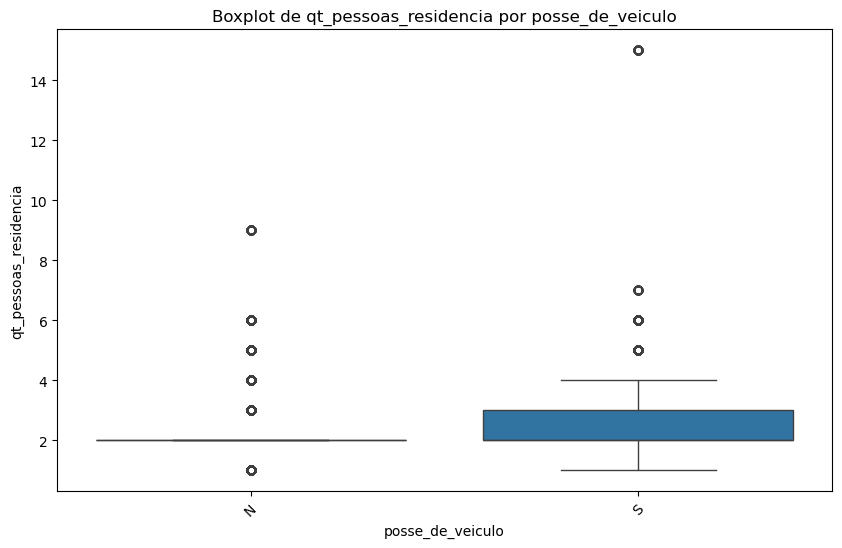

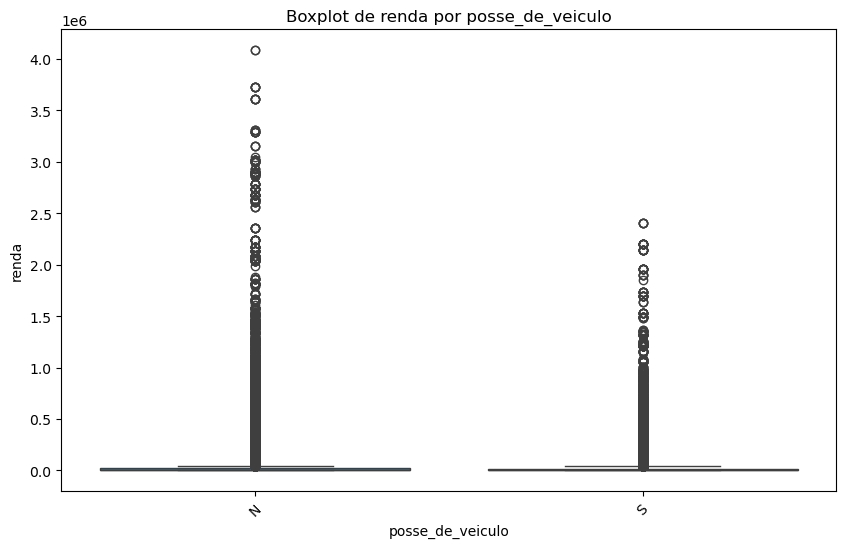

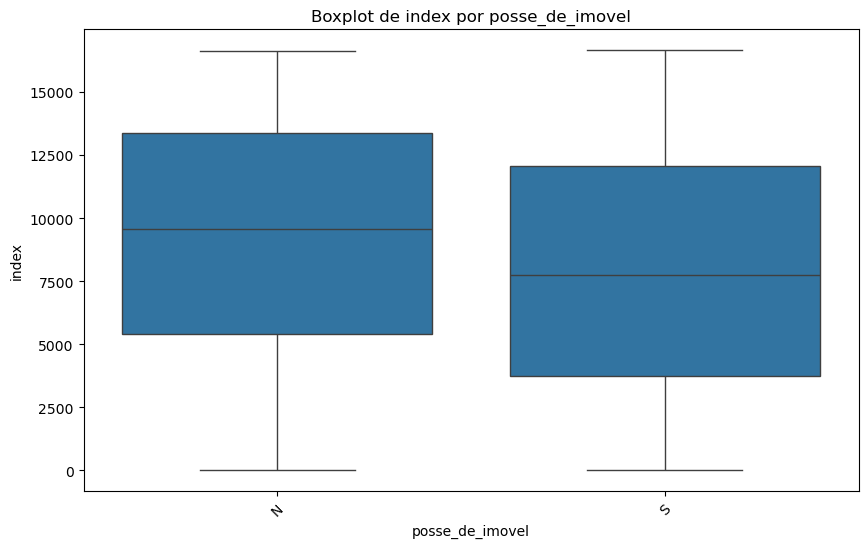

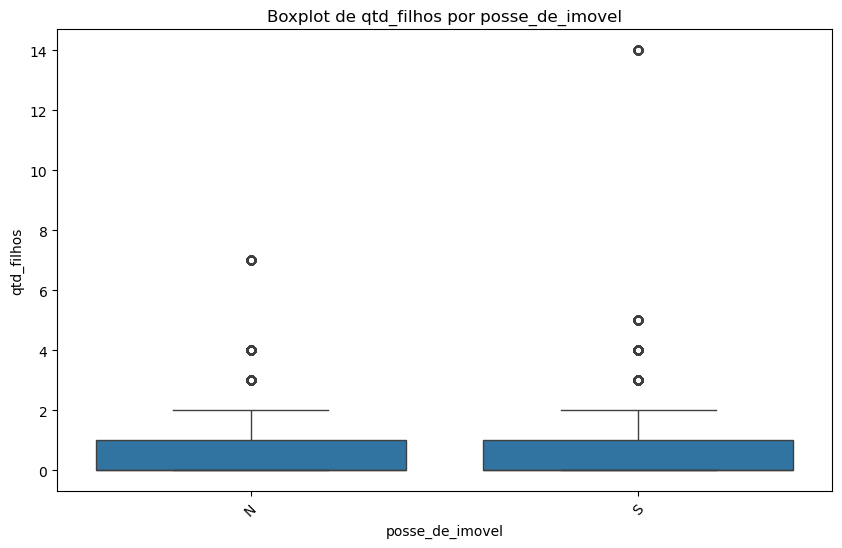

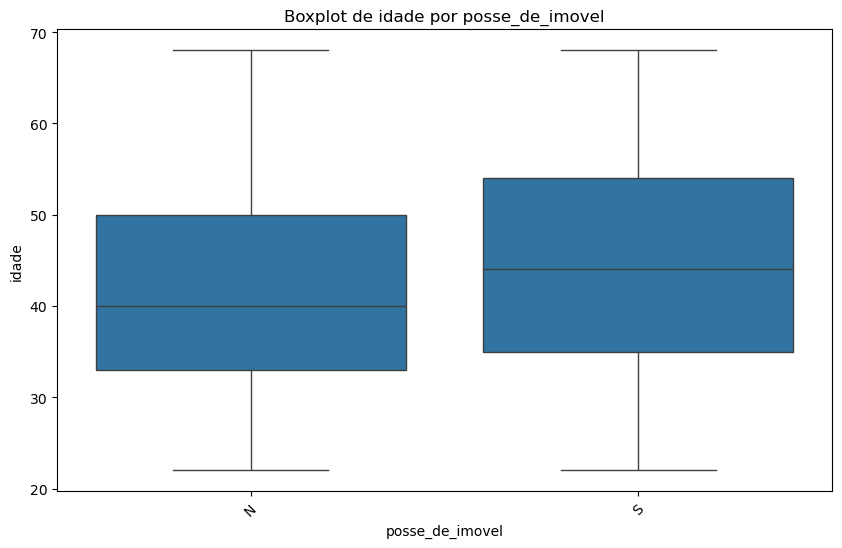

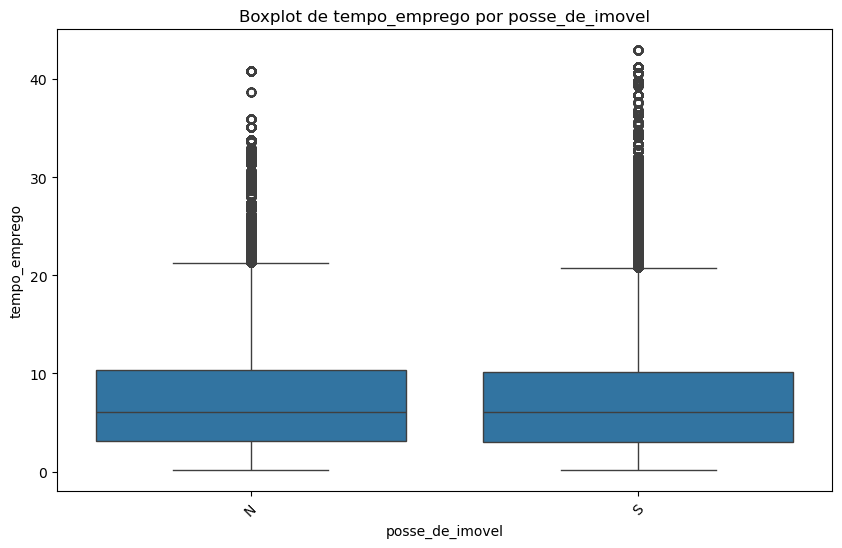

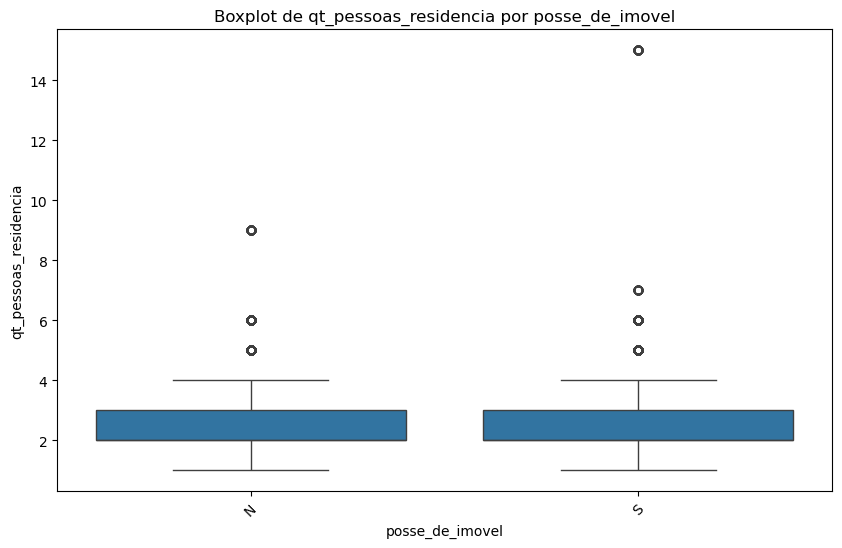

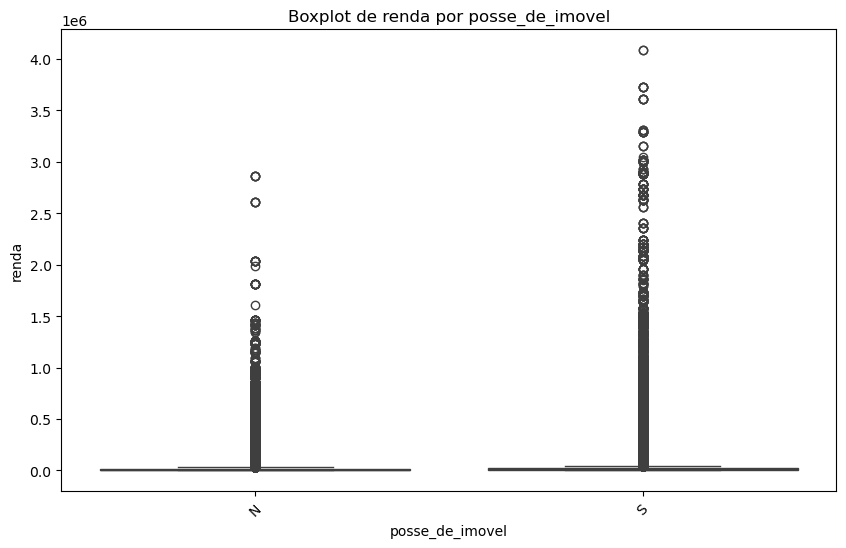

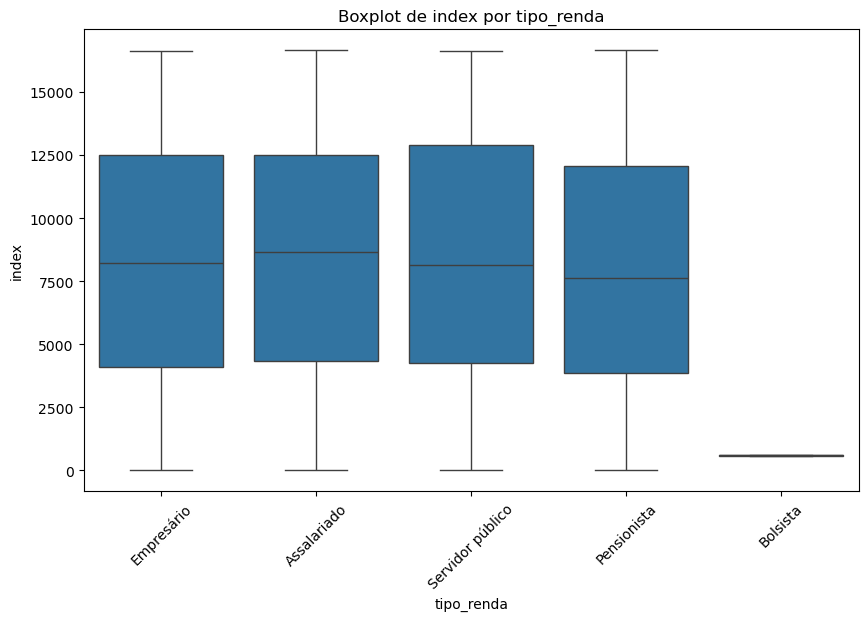

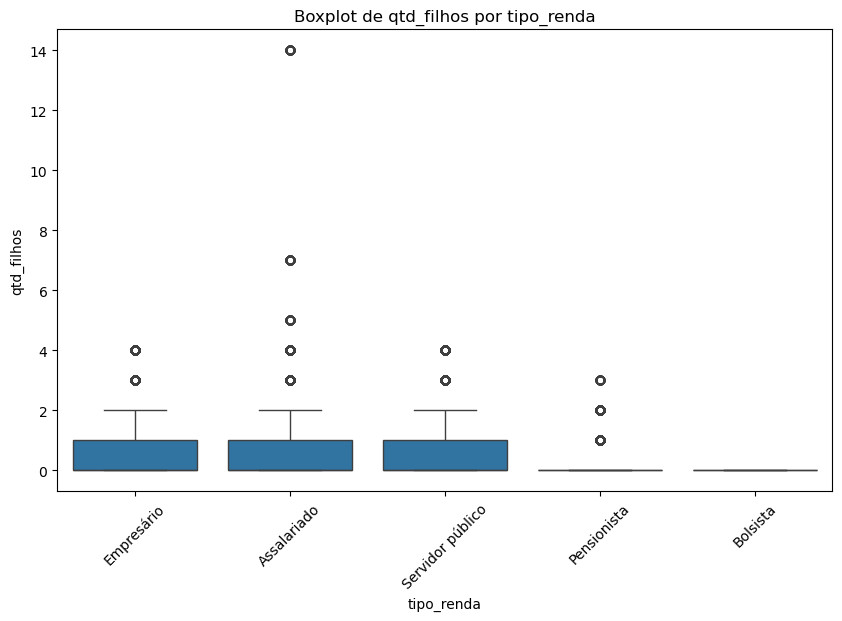

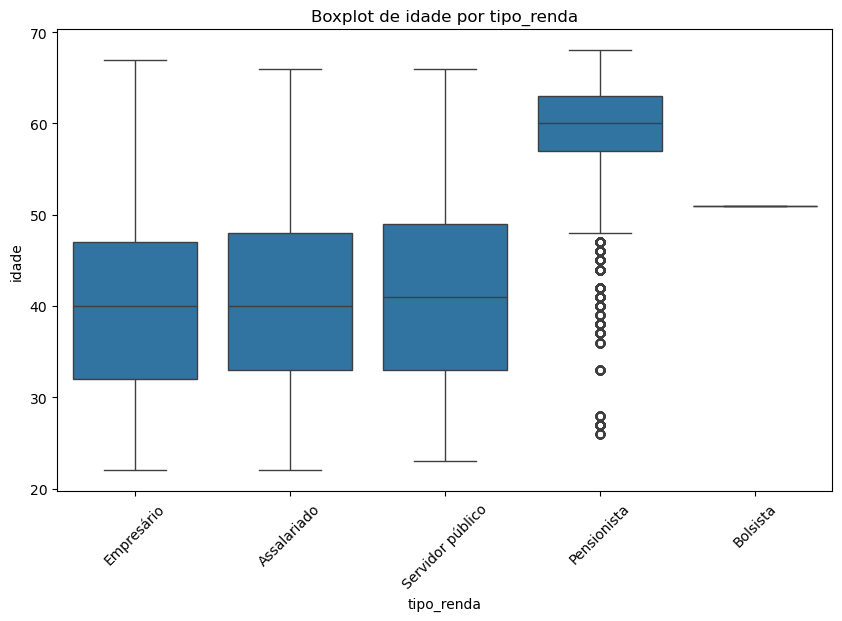

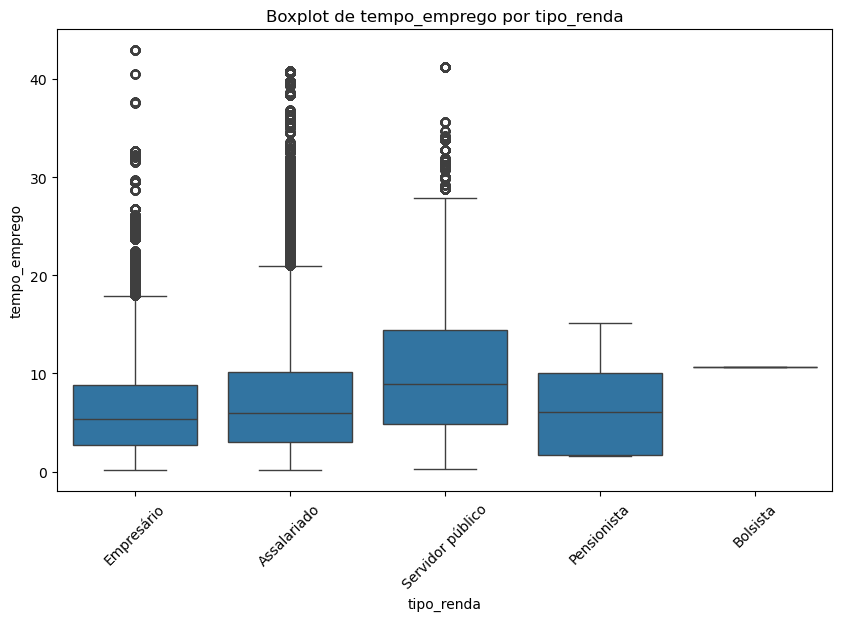

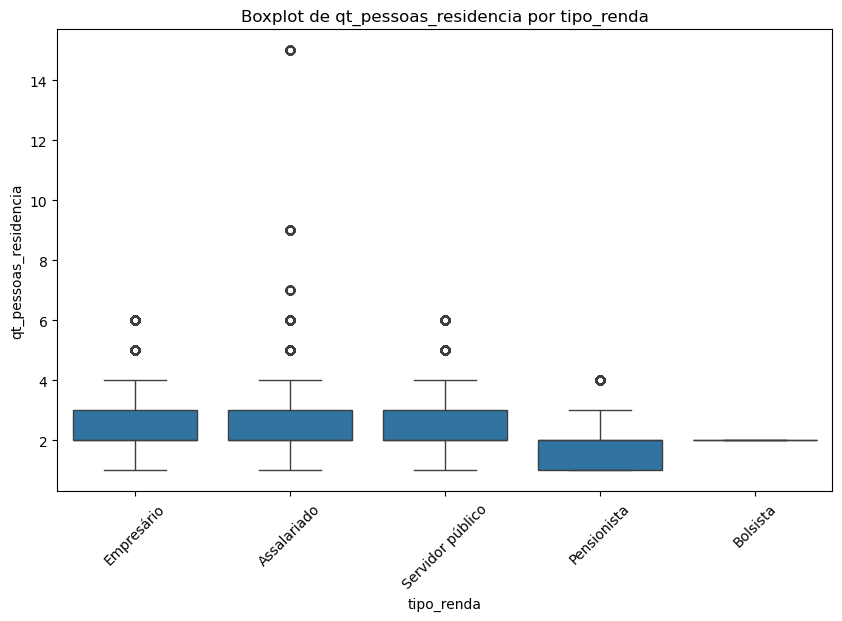

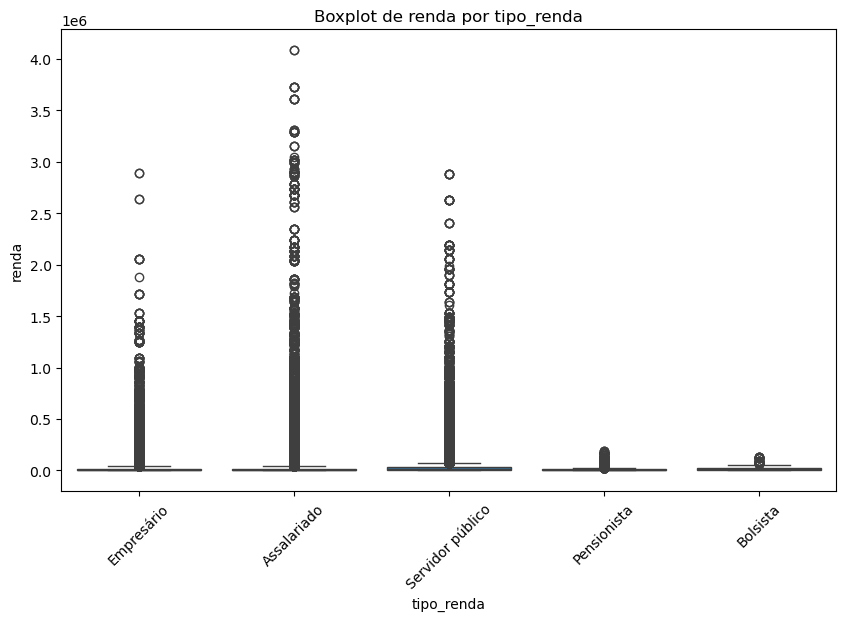

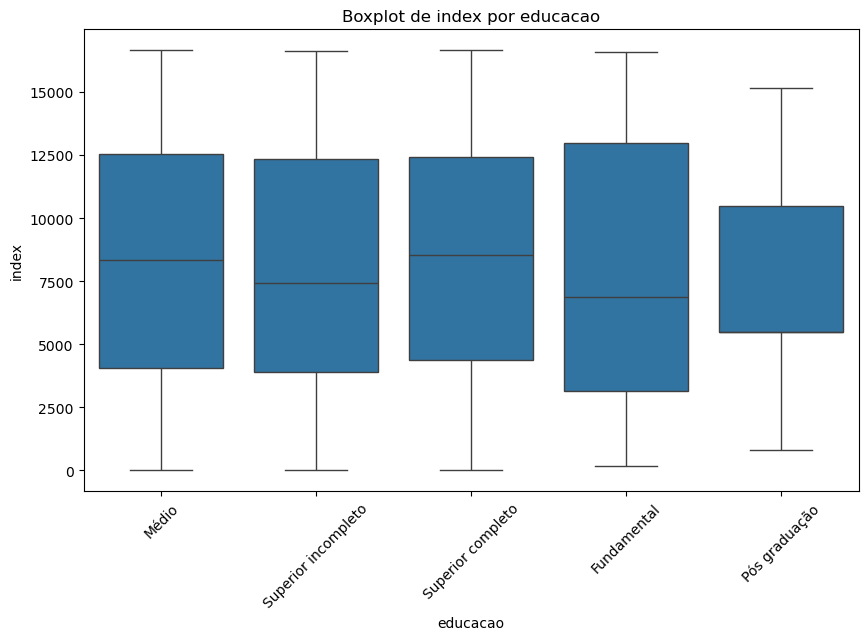

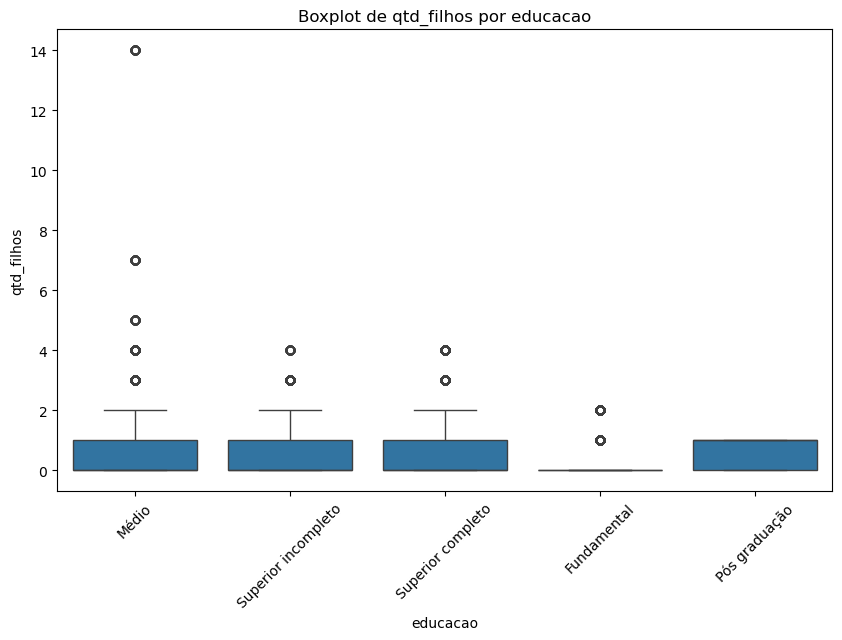

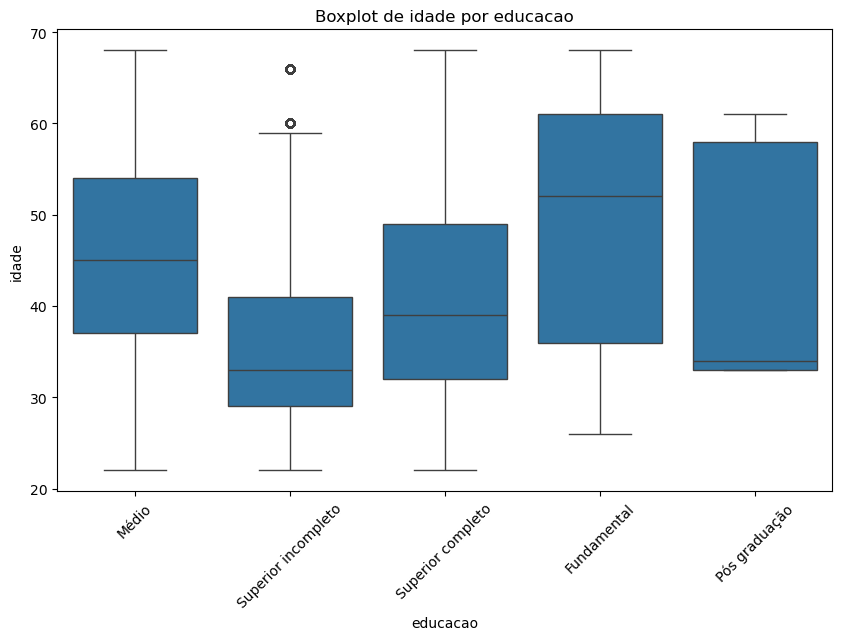

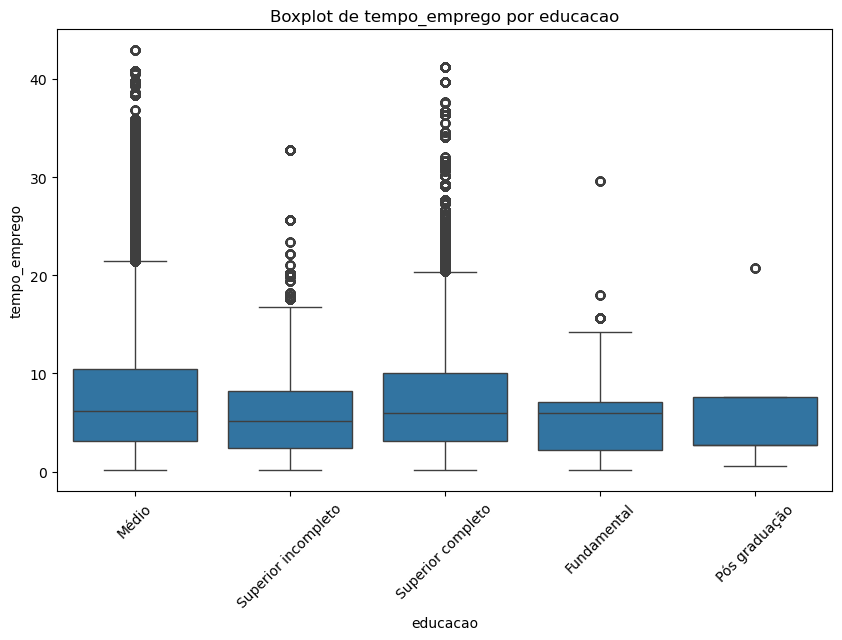

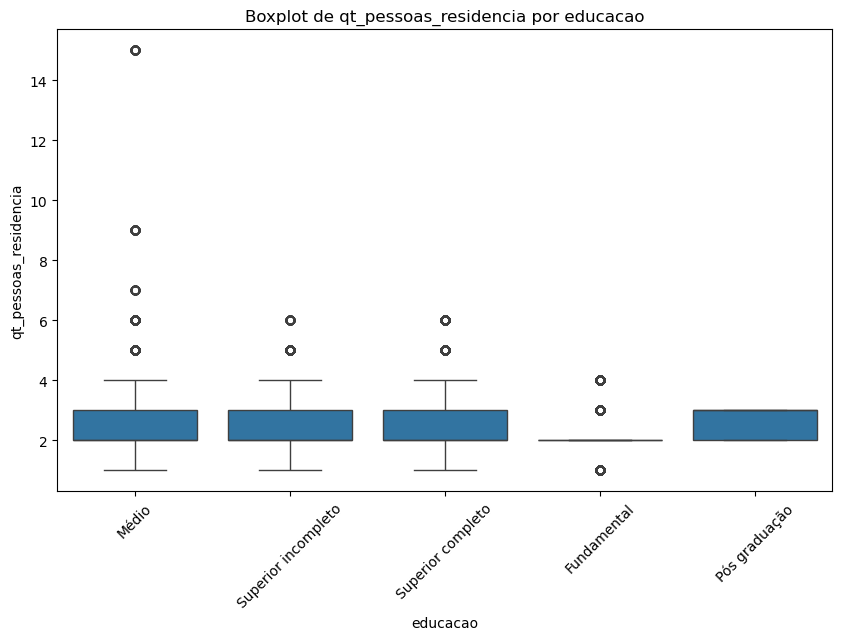

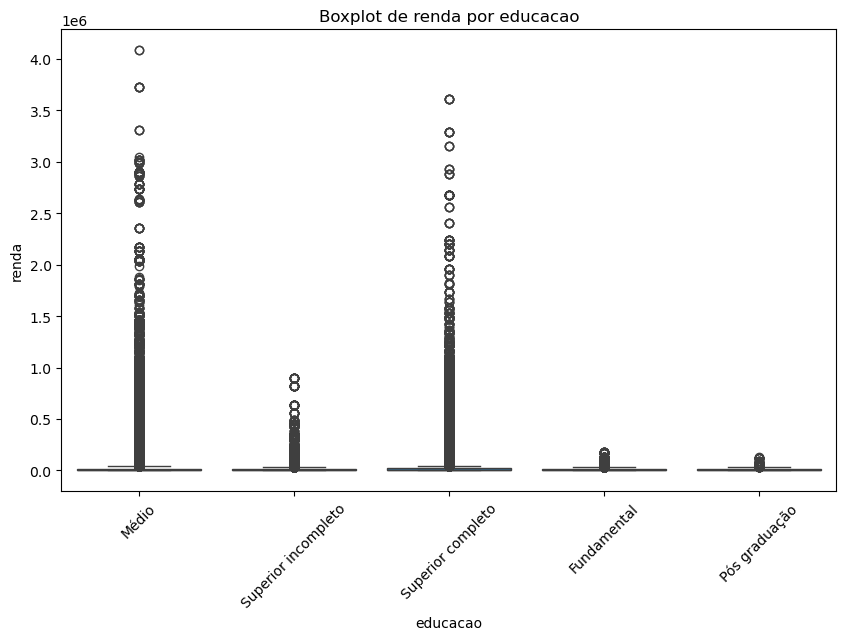

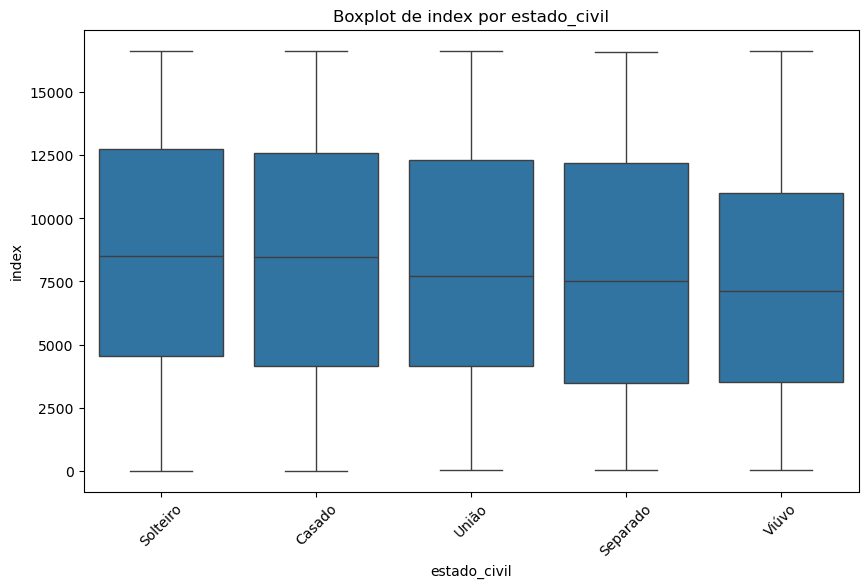

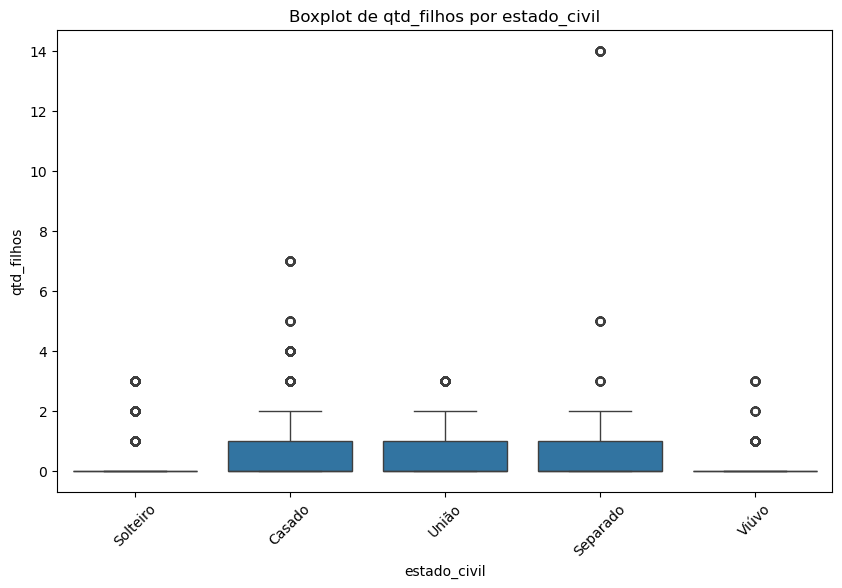

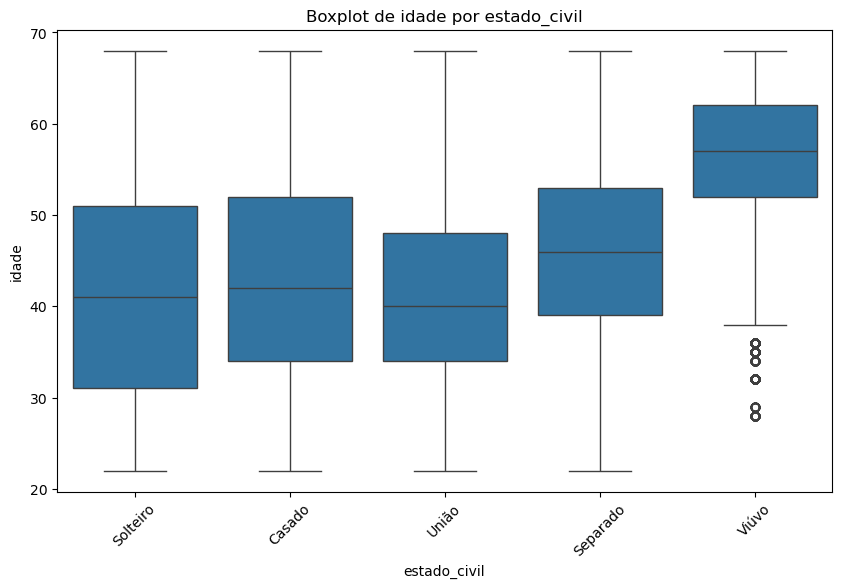

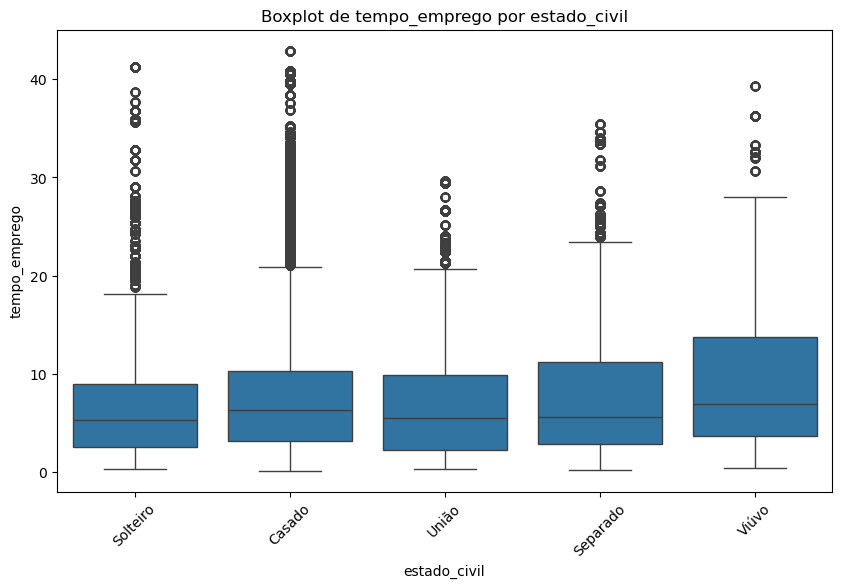

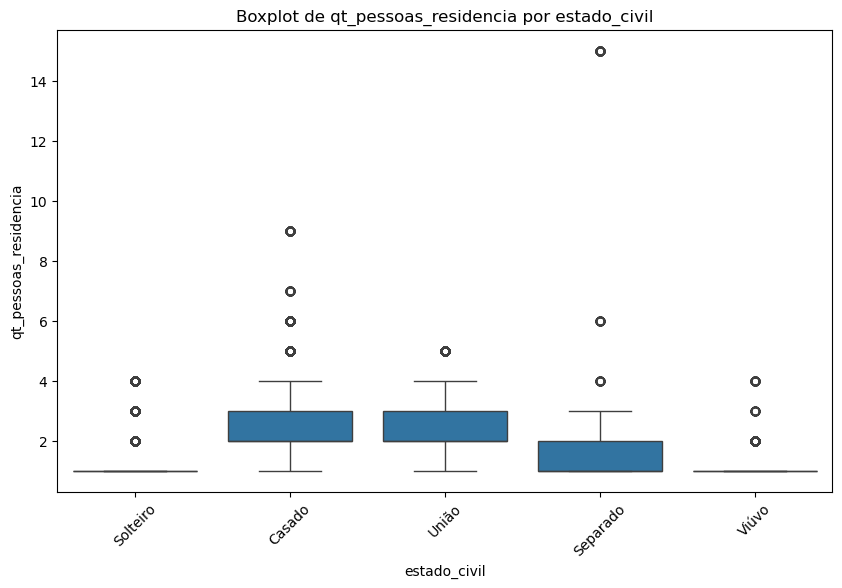

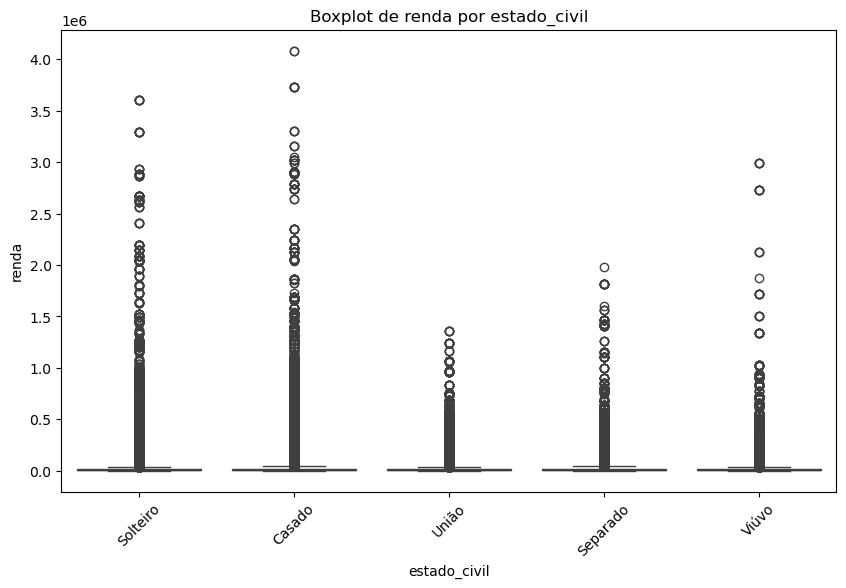

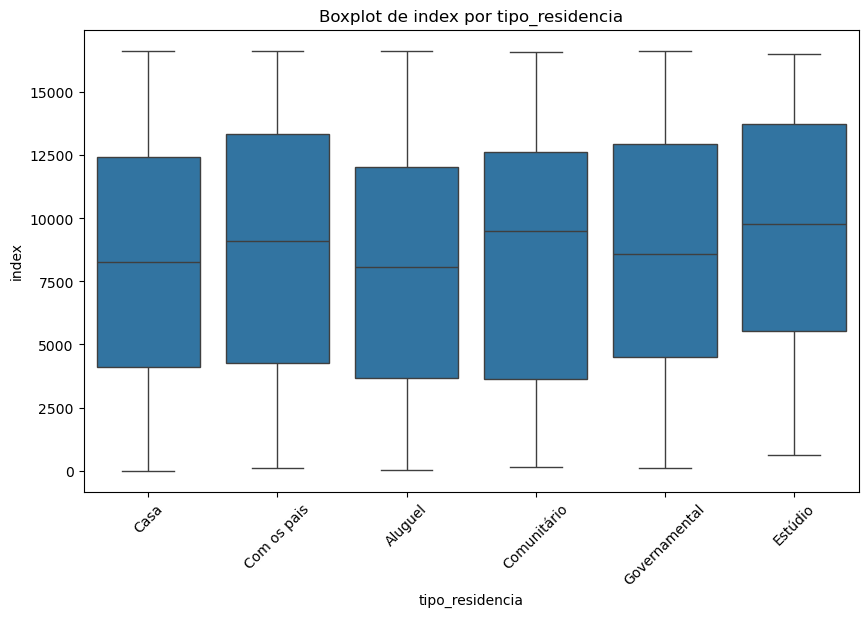

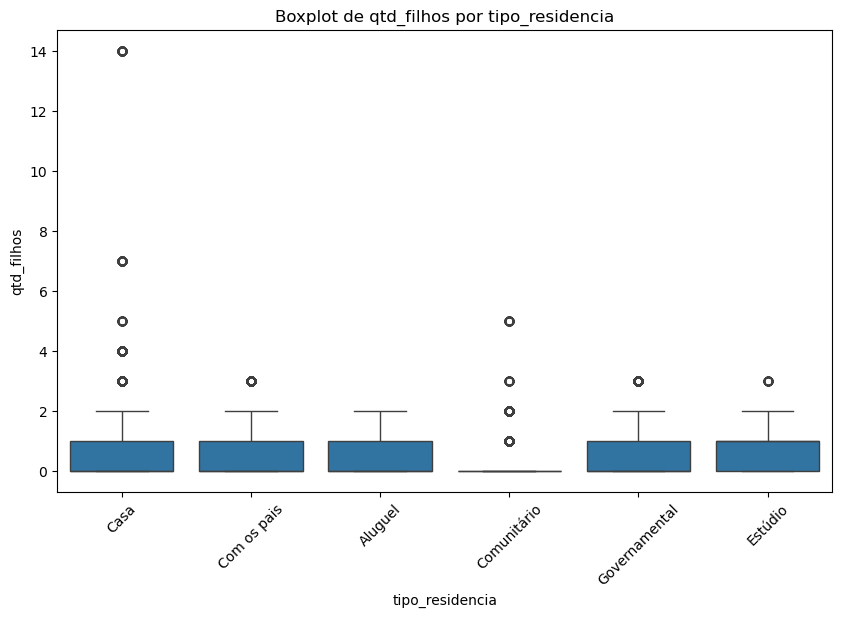

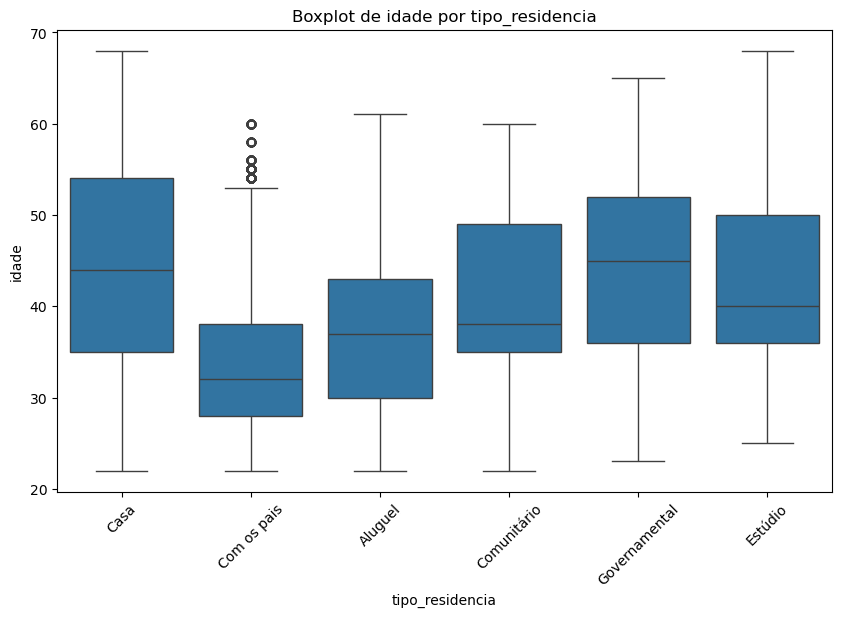

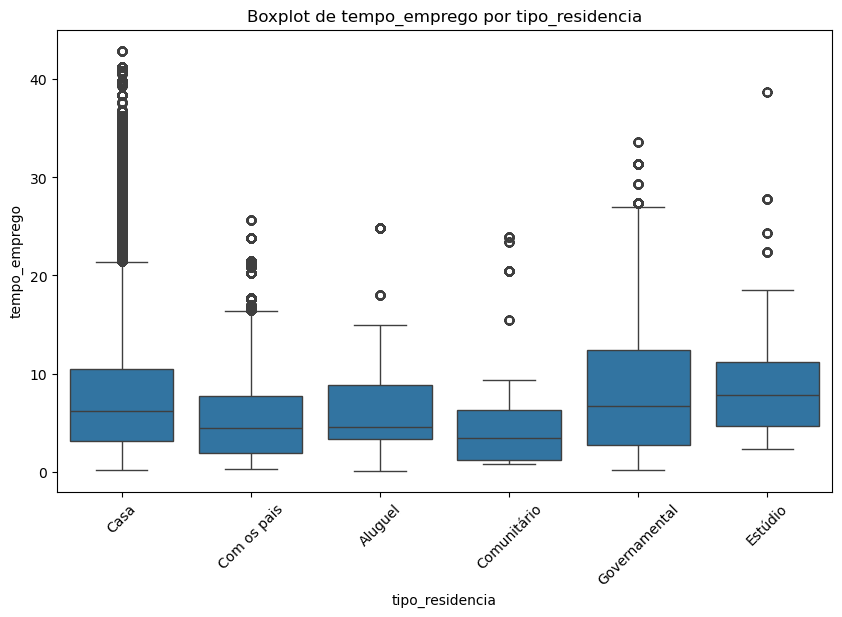

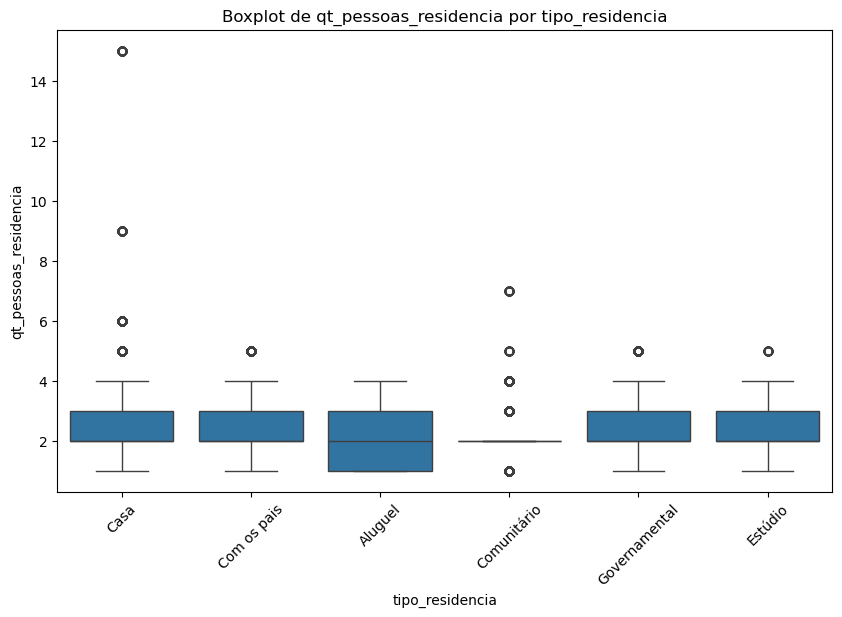

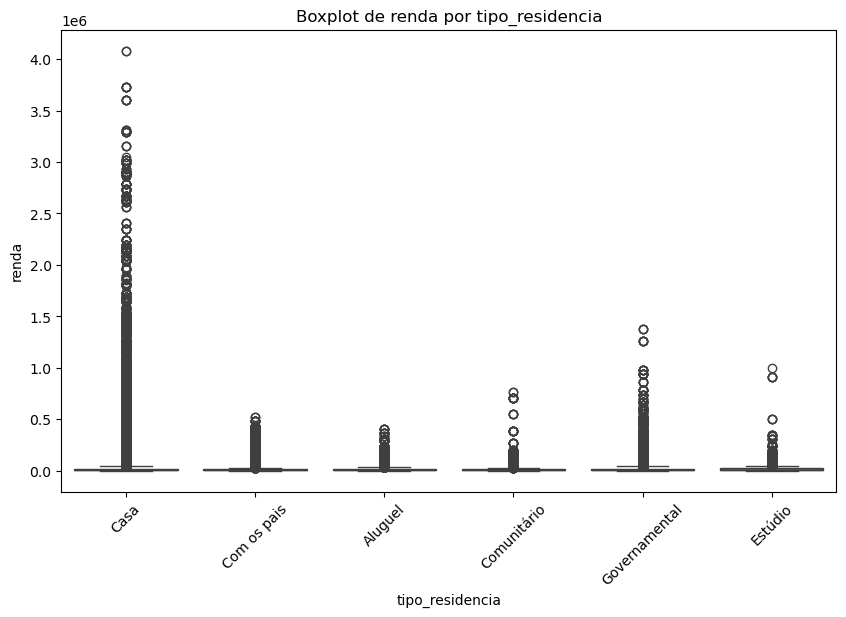

In [19]:
variaveis_quantitativas = df.select_dtypes(include=['float64', 'int64']).columns

correlacao = df[variaveis_quantitativas].corr()
print("Matriz de Correlação:")
print(correlacao)


plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()


variaveis_qualitativas = df.select_dtypes(include=['object']).columns


for i in range(len(variaveis_qualitativas)):
    for j in range(i + 1, len(variaveis_qualitativas)):
        tabela_contingencia = pd.crosstab(df[variaveis_qualitativas[i]], df[variaveis_qualitativas[j]])
        print(f"\nTabela de Contingência entre {variaveis_qualitativas[i]} e {variaveis_qualitativas[j]}:")
        print(tabela_contingencia)


for qual in variaveis_qualitativas:
    for quant in variaveis_quantitativas:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[qual], y=df[quant])
        plt.title(f"Boxplot de {quant} por {qual}")
        plt.xticks(rotation=45)
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [21]:
" + ".join(list(treinamento.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau'

In [22]:
# Tratamento de valores ausentes
treinamento['tempo_emprego'].fillna(treinamento['tempo_emprego'].median(), inplace=True)
validacao_oot['tempo_emprego'].fillna(validacao_oot['tempo_emprego'].median(), inplace=True)  

# Tratamento de zeros estruturais
treinamento['renda'] = treinamento['renda'].replace(0, np.nan)  # Exemplo, substituindo zeros por NaN
treinamento['tem_veiculo'] = np.where(treinamento['posse_de_veiculo'] == 0, 0, 1)  
validacao_oot['tem_veiculo'] = np.where(validacao_oot['posse_de_veiculo'] == 0, 0, 1)  


# Tratamento de outliers
for col in ['renda', 'idade']:  # Exemplo de colunas
    treinamento = treinamento[(treinamento[col] < treinamento[col].quantile(0.95)) & (treinamento[col] > treinamento[col].quantile(0.05))]

In [23]:
formula = '''mau ~  sexo + posse_de_imovel + qtd_filhos + tipo_renda + 
            educacao + estado_civil +  idade + tempo_emprego + renda  + tem_veiculo'''

rl = smf.glm(formula, data=treinamento, family= sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               478071
Model:                                     GLM   Df Residuals:                   478052
Model Family:                         Binomial   Df Model:                           18
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -90636.
Date:                         Mon, 26 Aug 2024   Deviance:                   1.8127e+05
Time:                                 19:55:15   Pearson chi2:                 1.21e+06
No. Iterations:                              8   Pseudo R-squ. (CS):            0.02704
Covariance Type:                     nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.9775      0.037     26.172      0.000       0.904       1.051
sexo[T.M]                           0.0418      0.015      2.850      0.004       0.013       0.071
posse_de_imovel[T.S]                0.0499      0.014      3.549      0.000       0.022       0.077
tipo_renda[T.Bolsista]             -0.1430      0.300     -0.477      0.633      -0.730       0.444
tipo_renda[T.Empresário]            0.0124      0.017      0.750      0.454      -0.020       0.045
tipo_renda[T.Pensionista]           0.0738      0.024      3.109      0.002       0.027       0.120
tipo_renda[T.Servidor público]      0.0072      0.027      0.269      0.788      -0.045       0.060
educacao[T.Médio]                   0.0173      0.063      0.276      0.783      -0.105       0.140
educacao[T.Pós graduação]          -0.0821      0.183     -0.449      0.653      -0.440       0.276
educacao[T.Superior completo]       0.0361      0.064      0.568      0.570      -0.089       0.161
educacao[T.Superior incompleto]     0.0010      0.071      0.014      0.989      -0.138       0.140
estado_civil[T.Separado]           -0.0081      0.028     -0.285      0.776      -0.064       0.048
estado_civil[T.Solteiro]           -0.0359      0.022     -1.651      0.099      -0.078       0.007
estado_civil[T.União]              -0.0674      0.024     -2.777      0.005      -0.115      -0.020
estado_civil[T.Viúvo]               0.0167      0.036      0.461      0.644      -0.054       0.088
qtd_filhos                         -0.0147      0.010     -1.549      0.121      -0.033       0.004
idade                              -0.0025      0.001     -2.758      0.006      -0.004      -0.001
tempo_emprego                       0.0109      0.002      5.572      0.000       0.007       0.015
renda                            8.932e-05   1.18e-06     75.607      0.000     8.7e-05    9.16e-05
tem_veiculo                         0.9775      0.037     26.172      0.000       0.904       1.051
===================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [ ]:
# Fazer previsões no conjunto de treinamento e validação
y_scores_train = rl.predict(treinamento)
y_scores_oot = rl.predict(validacao_oot)

# Convertendo a variável resposta para numpy array para métricas
y_true_train = treinamento['mau'].values
y_true_oot = validacao_oot['mau'].values

# Acurácia
def accuracy(y_true, y_scores, threshold=0.5):
    y_pred = y_scores > threshold
    return accuracy_score(y_true, y_pred)

accuracy_train = accuracy(y_true_train, y_scores_train)
accuracy_oot = accuracy(y_true_oot, y_scores_oot)

# Teste de Kolmogorov-Smirnov (KS)
def ks_statistic(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return np.max(tpr - fpr)

ks_train = ks_statistic(y_true_train, y_scores_train)
ks_oot = ks_statistic(y_true_oot, y_scores_oot)

# Índice de Gini
def gini_coefficient(y_true, y_scores):
    auc = roc_auc_score(y_true, y_scores)
    return 2 * auc - 1

gini_train = gini_coefficient(y_true_train, y_scores_train)
gini_oot = gini_coefficient(y_true_oot, y_scores_oot)

# Exibindo os resultados
print(f'Acurácia no conjunto de treino: {accuracy_train:.4f}')
print(f'Acurácia no conjunto de validação (out of time): {accuracy_oot:.4f}')
print(f'KS no conjunto de treino: {ks_train:.4f}')
print(f'KS no conjunto de validação (out of time): {ks_oot:.4f}')
print(f'Índice de Gini no conjunto de treino: {gini_train:.4f}')
print(f'Índice de Gini no conjunto de validação (out of time): {gini_oot:.4f}')

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [36]:
null_summary = df.isnull().sum()
null_columns = null_summary[null_summary > 0]
null_column_types = df[null_columns.index].dtypes

null_summary, null_column_types

(data_ref                      0
 index                         0
 sexo                          0
 posse_de_veiculo              0
 posse_de_imovel               0
 qtd_filhos                    0
 tipo_renda                    0
 educacao                      0
 estado_civil                  0
 tipo_residencia               0
 idade                         0
 tempo_emprego            125957
 qt_pessoas_residencia         0
 renda                         0
 mau                           0
 mes                           0
 dtype: int64,
 tempo_emprego    float64
 dtype: object)

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [44]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

In [46]:
for column in df.select_dtypes(include=[np.number]).columns:
    df = remove_outliers(df, column)
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau      mes  
0       6.873973                    1.0   2515.39  False  2015-01  
1       4.526027                    2.0   3180.19  False  2015-01  
2       0.243836                    4.0   1582.29  False  2015-01  
3      12.772603                    2.0  13721.17  False  2015-01  
4       8.432877                    1.0   2891.08  False  2015-01

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [68]:
df2 = df.sample(10000)

In [74]:
def calculate_woe_iv(df2, feature, target):
    lst = []
    for i in range(df2[feature].nunique()):
        val = df2[feature].unique()[i]
        lst.append({
            'Value': val,
            'All': df2[df2[feature] == val].count()[feature],
            'Good': df2[(df2[feature] == val) & (df2[target] == 0)].count()[feature],
            'Bad': df2[(df2[feature] == val) & (df2[target] == 1)].count()[feature]
        })
        
    df_woe_iv = pd.DataFrame(lst)
    df_woe_iv['Distr_Good'] = df_woe_iv['Good'] / df_woe_iv['Good'].sum()
    df_woe_iv['Distr_Bad'] = df_woe_iv['Bad'] / df_woe_iv['Bad'].sum()
    df_woe_iv['WOE'] = np.log(df_woe_iv['Distr_Good'] / df_woe_iv['Distr_Bad'])
    df_woe_iv['IV'] = (df_woe_iv['Distr_Good'] - df_woe_iv['Distr_Bad']) * df_woe_iv['WOE']
    iv = df_woe_iv['IV'].sum()
    
    return df_woe_iv, iv

In [76]:
iv_list = []
for column in df2.columns:
    if column != 'mau':  
        _, iv = calculate_woe_iv(df2, column, 'mau')
        iv_list.append((column, iv))


iv_df = pd.DataFrame(iv_list, columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)
print(iv_df)

                  Feature        IV
1                   index       inf
10                  idade       inf
11          tempo_emprego       inf
13                  renda       inf
0                data_ref  0.290853
14                    mes  0.290853
2                    sexo  0.007665
7                educacao  0.007316
6              tipo_renda  0.006360
9         tipo_residencia  0.005974
4         posse_de_imovel  0.003268
8            estado_civil  0.002619
5              qtd_filhos  0.001577
12  qt_pessoas_residencia  0.001271
3        posse_de_veiculo  0.000544


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [ ]:
X = df.drop('mau', axis=1)  
y = df['mau']  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5) 
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])


pca_df['mau'] = y

print(pca_df.head())

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [88]:
df_dummies = pd.get_dummies(df, columns=[
    'sexo', 
    'posse_de_veiculo', 
    'posse_de_imovel', 
    'tipo_renda', 
    'educacao', 
    'estado_civil', 
    'tipo_residencia'
])

print(df_dummies)

        data_ref  index  qtd_filhos  idade  tempo_emprego  \
0          16436   5733           0     43       6.873973   
1          16436    727           0     35       4.526027   
2          16436   6374           2     31       0.243836   
3          16436   9566           0     54      12.772603   
4          16436   9502           0     31       8.432877   
...          ...    ...         ...    ...            ...   
749993     16861   7043           0     51      13.298630   
749995     16861  13689           0     48       3.038356   
749997     16861  14023           2     43      10.375342   
749998     16861   2396           0     56      13.780822   
749999     16861  14026           2     43      10.375342   

        qt_pessoas_residencia     renda    mau      mes  sexo_F  ...  \
0                         1.0   2515.39  False  2015-01    True  ...   
1                         2.0   3180.19  False  2015-01    True  ...   
2                         4.0   1582.29  False  201

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [117]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'mes'],
      dtype='object')

In [125]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
        
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.lower_bounds_ = X.quantile(0.25) - (self.threshold * (X.quantile(0.75) - X.quantile(0.25)))
            self.upper_bounds_ = X.quantile(0.75) + (self.threshold * (X.quantile(0.75) - X.quantile(0.25)))
        return self
        
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.copy()
            for col in X.columns:
                lower = self.lower_bounds_[col]
                upper = self.upper_bounds_[col]
                X = X[(X[col] >= lower) & (X[col] <= upper)]
        return X


In [129]:
numeric_features = ['idade', 'renda']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('outlier_remover', OutlierRemover(threshold=1.5)),
    ('scaler', StandardScaler())
])


categorical_features = ['posse_de_veiculo']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))  
])


X_processed = pipeline.fit_transform(df)

df_processed = pd.DataFrame(X_processed, columns=[f'PC{i+1}' for i in range(X_processed.shape[1])])
df_processed

PC1       PC2
0      -0.316236 -0.888500
1      -0.877763 -0.151287
2      -1.349149 -0.094890
3       1.863938 -0.364484
4      -1.219455  0.115900
...          ...       ...
474154  1.823535  0.054951
474155  0.019510 -1.315198
474156 -0.564883 -1.061620
474157  0.885029 -1.664758
474158 -0.110697 -0.600748

[474159 rows x 2 columns]

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [2]:
from pycaret.classification import *

In [12]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

In [18]:
df2 = df.sample(10000)

In [19]:
clf1 = setup(data=df2, target='mau')

In [20]:
best_model = compare_models(fold=5)

#### Criar o Modelo

In [21]:
model_1 = create_model('lightgbm')

#### Tunando o modelo

In [22]:
model_1_tunned = tune_model(model_1)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


#### Graficos do modelo

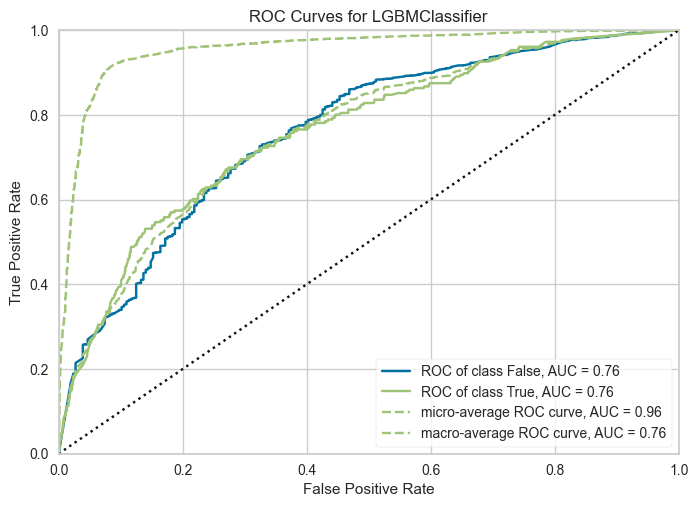

In [23]:
plot_model(model_1_tunned, plot="auc" )

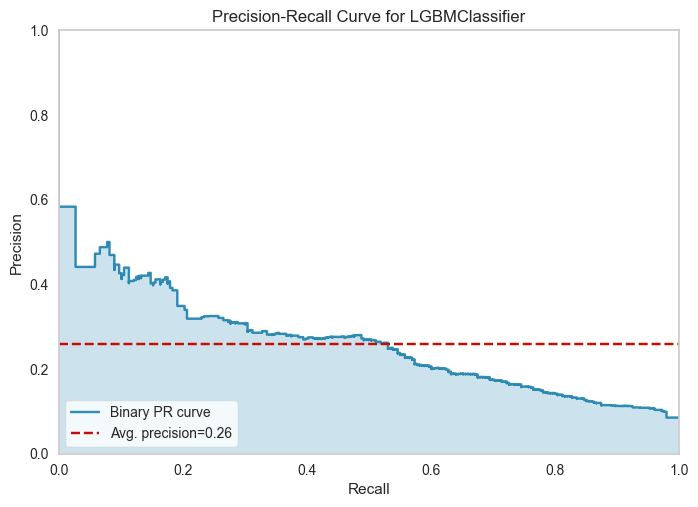

In [28]:
plot_model(model_1_tunned, plot='pr')

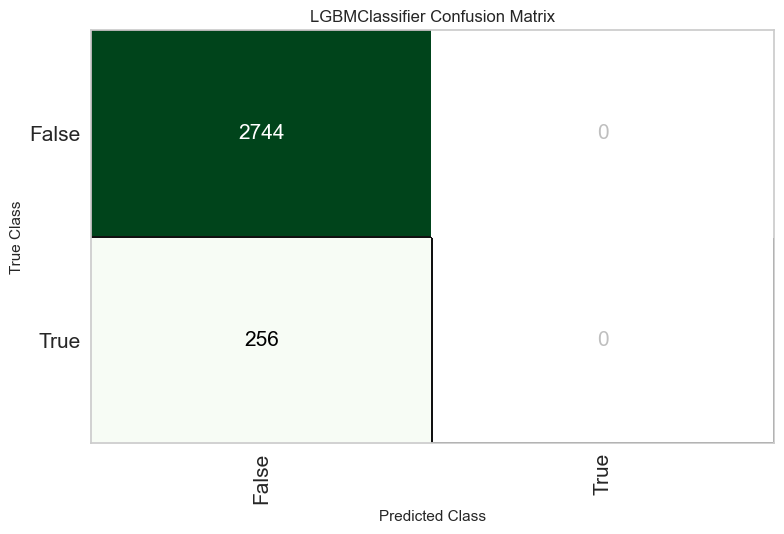

In [29]:
plot_model(model_1_tunned, plot='confusion_matrix')

In [30]:
predict_model(model_1_tunned);

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [31]:
final_model = finalize_model(model_1_tunned)

In [32]:
print(final_model)

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=Sim...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.9,
                                importance_type='split', lear

In [35]:
predict_model(final_model);

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [38]:
save_model(final_model, 'Modelo 1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.9,
                                 importance_typ